In [1]:
# Importing necessary libraries:
import torch
import torchvision
import torchvision.transforms as T
from torch import nn
from torchvision.datasets import STL10
from torch.utils.data.dataloader import DataLoader

In [2]:
# Device agnostic code:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"The current device torch is on: {device}")

The current device torch is on: cuda


In [3]:
transform = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor()
])

print(f"Transformation pipeline:\n{transform}")

Transformation pipeline:
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [4]:
# Training and testing dataset
train_data = STL10(root = "dataset", split = "train", transform = transform, download = True)
test_data = STL10(root = "dataset", split = "test", transform = transform, download = True)

100%|██████████| 2640397119/2640397119 [00:46<00:00, 57002768.34it/s]


Extracting dataset/stl10_binary.tar.gz to dataset
Files already downloaded and verified


In [5]:
print(f"Length of training_data: {len(train_data)}")
print(f"Length of testing data: {len(test_data)}")

Length of training_data: 5000
Length of testing data: 8000


In [6]:
classes = train_data.classes
print(classes)

['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


(-0.5, 223.5, 223.5, -0.5)

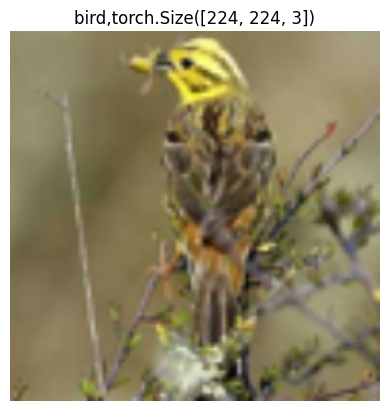

In [7]:
# Visualization:
import matplotlib.pyplot as plt

image = train_data[0][0].permute(1,2,0) # [channels, height, width] -> [height, width, channels]
label = train_data[0][1]

# Plot image
plt.figure()
plt.imshow(image)
plt.title(f"{classes[label]},{image.shape}")
plt.axis(False)

In [8]:
# Coverting train and test datasets into DataLoaders
BATCH_SIZE = 64
train_dataloader = DataLoader(dataset=train_data, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(dataset=test_data, batch_size = BATCH_SIZE, shuffle = False)

print(f"Length of train_dataloader:{len(list(next(iter(train_dataloader)))[0])}")
print(f"Length of test_dataloader:{len(list(next(iter(test_dataloader)))[0])}")

Length of train_dataloader:64
Length of test_dataloader:64


In [22]:
# Define your ResNet-50 model
class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        # Define the architecture of ResNet-50
        # You can use torchvision.models to load a pre-defined ResNet-50
        # or implement it from scratch.
        self.resnet50 = torchvision.models.resnet50(pretrained=True)
        # Modify the final fully connected layer to match your number of classes
        self.resnet50.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        return self.resnet50(x)

In [23]:
model = ResNet50(num_classes = len(classes))
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 241MB/s]


ResNet50(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [24]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

In [25]:
model.to(device)
epochs = 10
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    train_acc = 0
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)

        y_logits = model(data)
        y_preds = torch.argmax(torch.softmax(y_logits, dim = 1), dim = 1)
        #print(y_preds.shape)
        #print(y_logits.shape, target.shape)
        loss = loss_fn(y_logits, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_acc += (y_preds == target).sum().item() / len(target)

        #y_pred_class = torch.argmax(torch.softmax(output, dim=1), dim=1)
        #train_acc = (y_pred_class == target).sum().item() / len(output)

        if (batch_idx + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Batch [{batch_idx + 1}/{len(train_dataloader)}], Loss: {total_loss / (batch_idx + 1):.4f}, Acc: {train_acc / (batch_idx +1):.4f}')

    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_dataloader):.4f}, Acc: {train_acc / (len(train_dataloader)):.4f}')

Epoch [1/10], Batch [10/79], Loss: 1.2436, Acc: 0.5969
Epoch [1/10], Batch [20/79], Loss: 1.2519, Acc: 0.5914
Epoch [1/10], Batch [30/79], Loss: 1.2013, Acc: 0.5943
Epoch [1/10], Batch [40/79], Loss: 1.1453, Acc: 0.6113
Epoch [1/10], Batch [50/79], Loss: 1.1341, Acc: 0.6112
Epoch [1/10], Batch [60/79], Loss: 1.1094, Acc: 0.6190
Epoch [1/10], Batch [70/79], Loss: 1.0691, Acc: 0.6324
Epoch [1/10], Loss: 1.0359, Acc: 0.6432
Epoch [2/10], Batch [10/79], Loss: 0.7384, Acc: 0.7328
Epoch [2/10], Batch [20/79], Loss: 0.6940, Acc: 0.7555
Epoch [2/10], Batch [30/79], Loss: 0.6855, Acc: 0.7562
Epoch [2/10], Batch [40/79], Loss: 0.6612, Acc: 0.7594
Epoch [2/10], Batch [50/79], Loss: 0.6489, Acc: 0.7638
Epoch [2/10], Batch [60/79], Loss: 0.6381, Acc: 0.7701
Epoch [2/10], Batch [70/79], Loss: 0.6278, Acc: 0.7739
Epoch [2/10], Loss: 0.6242, Acc: 0.7777
Epoch [3/10], Batch [10/79], Loss: 0.6258, Acc: 0.8078
Epoch [3/10], Batch [20/79], Loss: 0.5595, Acc: 0.8133
Epoch [3/10], Batch [30/79], Loss: 0.539

In [34]:
img, label = test_data[0][0], test_data[0][1]
# torch.unsqueeze(dim = )
img.unsqueeze(dim=0), img.unsqueeze(dim=0).shape, classes[label]

(tensor([[[[0.8902, 0.8902, 0.8902,  ..., 0.8941, 0.8980, 0.8980],
           [0.8902, 0.8902, 0.8902,  ..., 0.8941, 0.8980, 0.8980],
           [0.8902, 0.8902, 0.8863,  ..., 0.8980, 0.8941, 0.8941],
           ...,
           [0.8980, 0.8902, 0.8745,  ..., 0.7490, 0.7333, 0.7255],
           [0.8824, 0.8824, 0.8824,  ..., 0.7059, 0.6980, 0.6941],
           [0.8784, 0.8784, 0.8824,  ..., 0.6941, 0.6863, 0.6824]],
 
          [[0.9216, 0.9216, 0.9216,  ..., 0.9176, 0.9216, 0.9216],
           [0.9216, 0.9216, 0.9216,  ..., 0.9176, 0.9216, 0.9216],
           [0.9216, 0.9216, 0.9216,  ..., 0.9137, 0.9176, 0.9176],
           ...,
           [0.7333, 0.7294, 0.7137,  ..., 0.6039, 0.5882, 0.5843],
           [0.7176, 0.7137, 0.7176,  ..., 0.5725, 0.5569, 0.5529],
           [0.7098, 0.7098, 0.7176,  ..., 0.5608, 0.5451, 0.5412]],
 
          [[0.9294, 0.9294, 0.9294,  ..., 0.9255, 0.9216, 0.9216],
           [0.9294, 0.9294, 0.9294,  ..., 0.9255, 0.9216, 0.9216],
           [0.9294, 0.92

In [39]:
# Inferencing on test_dataset:
model.eval()
with torch.inference_mode():
  single_pred = model(img.unsqueeze(dim=0).to(device))

print(f"Prediction: {classes[single_pred.argmax(dim=1)]}")

Prediction: horse


In [46]:
# Checking multiple predicitons
test_batch_labels = next(iter(test_dataloader))[1]
test_batch_images = next(iter(test_dataloader))[0]

predictions = model(test_batch_images.to(device))
print(predictions.argmax(dim=1) == test_batch_labels.to(device))

tensor([ True, False, False,  True,  True,  True, False,  True,  True, False,
         True,  True, False,  True, False,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False,  True, False,  True,  True, False, False,  True, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True, False,  True,  True], device='cuda:0')


In [49]:
for pred in predictions:
  print(classes[pred.argmax(dim=0)])

horse
bird
deer
airplane
cat
bird
horse
bird
deer
bird
airplane
airplane
bird
airplane
monkey
dog
deer
car
airplane
horse
dog
cat
bird
cat
car
horse
dog
dog
car
cat
car
horse
monkey
monkey
truck
airplane
cat
monkey
car
bird
bird
truck
airplane
horse
deer
truck
bird
bird
cat
car
cat
deer
airplane
airplane
truck
ship
horse
monkey
car
ship
airplane
monkey
bird
monkey
